In [1]:
from langchain_groq import ChatGroq
import os 
from dotenv import load_dotenv

load_dotenv()
llm = ChatGroq(
    temperature=0,
    groq_api_key = os.environ['GROQ_KEY'],
    model_name="llama-3.3-70b-versatile"
)

# result = llm.invoke("What is Langgraph?")
# print(result.content)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [2]:
from pydantic import BaseModel, Field
from typing import List
from typing_extensions import TypedDict

class Question(BaseModel):
    question: str = Field(
        question="The question asked by the examiner",
    )
    @property
    def qn(self) -> str:
        return f"Question: {self.question}\n"

class Perspectives(BaseModel):
    questions: List[Question] = Field(
        description="List of questions asked by the examiner",
    )

class GenerateQuestionsState(TypedDict):
    grade: str # Grade that examiner teaches
    subject: str # Subject that examiner teaches
    max_questions: int # Number of questions
    human_feedback: str # Human feedback
    questions: List[Question] # Questions asked by examiner

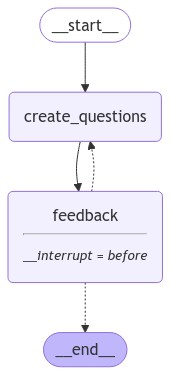

In [3]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

examiner_instructions="""You are an examiner tasked with creating questions that will have detailed answers. Follow these instructions carefully:

1. First, get the grade that the examiner teaches:
{grade}
        
2. Then, get the subject that the examiner teaches:
{subject}

3. Examine any feedback given to guide the creation of questions: 
        
{human_feedback}
    
4. Determine the questions appropriate for the grade and subject and consider human feedback if any.
                    
5. Return the top {max_questions} questions."""

def create_questions(state: GenerateQuestionsState):
    
    grade=state['grade']
    subject=state['subject']
    max_questions=state['max_questions']
    human_feedback=state.get('human_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = examiner_instructions.format(grade=grade,
                                                  subject=subject,
                                                  human_feedback=human_feedback, 
                                                  max_questions=max_questions)

    # Generate question 
    questions = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of questions.")])
    
    # Write the list of questionss to state
    return {"questions": questions.questions}

def feedback(state: GenerateQuestionsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateQuestionsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_feedback=state.get('human_feedback', None)
    if human_feedback:
        return "create_questions"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateQuestionsState)
builder.add_node("create_questions", create_questions)
builder.add_node("feedback", feedback)
builder.add_edge(START, "create_questions")
builder.add_edge("create_questions", "feedback")
builder.add_conditional_edges("feedback", should_continue, ["create_questions", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [4]:
grade = "8th"
subject = "history"
max_questions = 3
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"grade":grade,"subject":subject,"max_questions":max_questions}, thread, stream_mode="values"):
    # Review
    questions = event.get('questions', '')
    if questions:
        for idx,question in enumerate(questions):
            print(f"Question {idx}: {question.question}")
            print("-" * 50)  

Question 0: What were the primary causes of the American Revolution?
--------------------------------------------------
Question 1: How did the Industrial Revolution impact the daily lives of people in the 18th and 19th centuries?
--------------------------------------------------
Question 2: What were the major consequences of the Treaty of Versailles after World War I?
--------------------------------------------------


In [5]:
state = graph.get_state(thread)
state.next

('feedback',)

In [6]:
graph.update_state(thread, {"human_feedback": 
                            "Add one question related to India and rest for world"}, as_node="feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdadf9-c934-6adb-8002-2d753cc91b8e'}}

In [7]:
for event in graph.stream({"grade":grade,"subject":subject,"max_questions":max_questions}, thread, stream_mode="values"):
    # Review
    questions = event.get('questions', '')
    if questions:
        for idx,question in enumerate(questions):
            print(f"Question{idx}: {question.question}")
            print("-" * 50)  

Question0: What were the primary causes of the American Revolution?
--------------------------------------------------
Question1: How did the Industrial Revolution impact the daily lives of people in the 18th and 19th centuries?
--------------------------------------------------
Question2: What were the major consequences of the Treaty of Versailles after World War I?
--------------------------------------------------
Question0: What were the major factors that led to the Indian independence movement?
--------------------------------------------------
Question1: How did the ancient civilizations of Egypt and Mesopotamia contribute to the development of modern society?
--------------------------------------------------
Question2: What were the main causes and consequences of World War II?
--------------------------------------------------


In [8]:
further_feedack = None
graph.update_state(thread, {"human_feedback": 
                            further_feedack}, as_node="feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdadf9-d1eb-6f24-8006-2d9604d2d07b'}}

In [9]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [10]:
final_state = graph.get_state(thread)
final_state.next

()

In [11]:
import operator
from typing import  Annotated

class AnswerState(TypedDict):
    context: Annotated[list, operator.add]
    question: Question
    sections: list

In [12]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=2)
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

In [13]:
from langchain_core.messages import get_buffer_string

def search_web(state: AnswerState):
    
    """ Retrieve docs from web search """
    question = state["question"]
    # Search
    search_query = question.question
    search_docs = tavily_search.invoke(search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: AnswerState):
    
    """ Retrieve docs from wikipedia """
    
    question = state["question"]
    # Search
    search_query = question.question
    search_docs = WikipediaLoader(query=search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [14]:
section_writer_instructions = ''' You are a student tasked with writing a detailed answer for the question:{question}
Write the answer in markdown format using 
# for headings
## for subheadings '''
def write_section(state: AnswerState):

    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(question=question.question)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

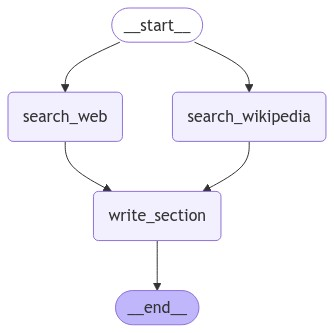

In [15]:
answer_builder = StateGraph(AnswerState)
answer_builder.add_node("search_web", search_web)
answer_builder.add_node("search_wikipedia", search_wikipedia)
answer_builder.add_node("write_section", write_section)

answer_builder.add_edge(START, "search_web")
answer_builder.add_edge(START, "search_wikipedia")
answer_builder.add_edge("search_web", "write_section")
answer_builder.add_edge("search_wikipedia", "write_section")
answer_builder.add_edge("write_section", END)

memory = MemorySaver()
answer_graph = answer_builder.compile(checkpointer=memory).with_config(run_name="Get answers")

# View
display(Image(answer_graph.get_graph().draw_mermaid_png()))

In [16]:
questions = final_state.values.get('questions')
questions[0]

Question(question='What were the major factors that led to the Indian independence movement?')

In [17]:
from IPython.display import Markdown
thread = {"configurable": {"thread_id": "1"}}
interview = answer_graph.invoke({"question":questions[0]}, thread)
Markdown(interview['sections'][0])

# Introduction to the Indian Independence Movement
The Indian independence movement was a series of historic events in South Asia with the ultimate aim of ending British colonial rule. It lasted until 1947, when the Indian Independence Act 1947 was passed. The movement was characterized by various factors, including socio-political, economic, and cultural elements.

## Early British Colonialism in India
The British established their presence in India in the early 17th century, with the first English trading post set up at Surat in 1613. Over the next two centuries, the British defeated the Portuguese and Dutch but remained in conflict with the French. The decline of the Mughal Empire in the first half of the 18th century allowed the British to establish a foothold in Indian politics.

## Factors Leading to the Indian Independence Movement
Several factors contributed to the rise of the Indian independence movement. These include:
* The introduction of the ryotwari system, which impacted lower-status cultivators by depleting their crops and leaving them impoverished.
* The 1882 Madras Forest Act, which restricted the free movement of adivasis in their forest habitats and prevented them from practicing their traditional form of agriculture.
* The partition of Bengal in 1905, which led to widespread protests and the formation of revolutionary groups.
* The influence of western-educated leaders, such as Lokmanya Tilak and Gopal Krishna Gokhale, who inspired several other freedom activists.
* The role of Mahatma Gandhi, who adopted a policy of non-violence and civil disobedience, and his followers, such as Jawaharlal Nehru and Vallabhbhai Patel.

## Revolutionary Movements
The Indian independence movement also saw the emergence of revolutionary groups, which believed in armed revolution against the British. These groups were mainly concentrated in Bengal, Bombay, Bihar, the United Provinces, and Punjab. Notable revolutionary leaders included Aurobindo Ghosh, Bhupendranath Datta, and Subodh Chandra Mullick, who formed the Jugantar party in 1906.

## Regional Movements
The Indian independence movement was not limited to a single region. Various regional movements emerged, including:
* The Bengal movement, which was led by leaders such as Dhaka district's Benoy Basu, Badal Gupta, and Dinesh Gupta.
* The Andhra Pradesh movement, which was led by leaders such as Uyyalawada Narasimha Reddy and Alluri Sitarama Raju.
* The Tamil Nadu movement, which was led by leaders such as Maveeran Alagumuthu Kone and Puli Thevar.

## Conclusion
The Indian independence movement was a complex and multifaceted phenomenon, driven by various factors, including socio-political, economic, and cultural elements. The movement saw the emergence of various regional and revolutionary groups, which ultimately contributed to the end of British colonial rule in India. The Indian Independence Act 1947 marked the beginning of a new era in Indian history, and the country has since become a sovereign nation, with a democratic government and a thriving economy.

In [18]:
class FinalGraphState(TypedDict):
    grade: str # Grade that examiner teaches
    subject: str # Subject that examiner teaches
    max_questions: int # Number of questions
    human_feedback: str # Human feedback
    questions: List[Question] # Questions asked by examiner
    sections: Annotated[list, operator.add] # Send() API key
    final_document: str # Final report

In [30]:
from langgraph.constants import Send

def initiate_all_answers(state: FinalGraphState):
    """ This is the "map" step where we run each question sub-graph"""    

    # Check if human feedback
    human_feedback=state.get('human_feedback')
    if human_feedback:
        return "create_questions"

    # Otherwise kick off answering in parallel via Send() API
    else:
        return [Send("get_answers", {"question": question}) for question in state["questions"]]
    
def final_guide(state: FinalGraphState):
    questions = state["questions"]
    answers = state["sections"]

    formatted_str_answers = "\n\n".join([f"Ans\n{answer}" for answer in answers])
    return {"final_document":formatted_str_answers}

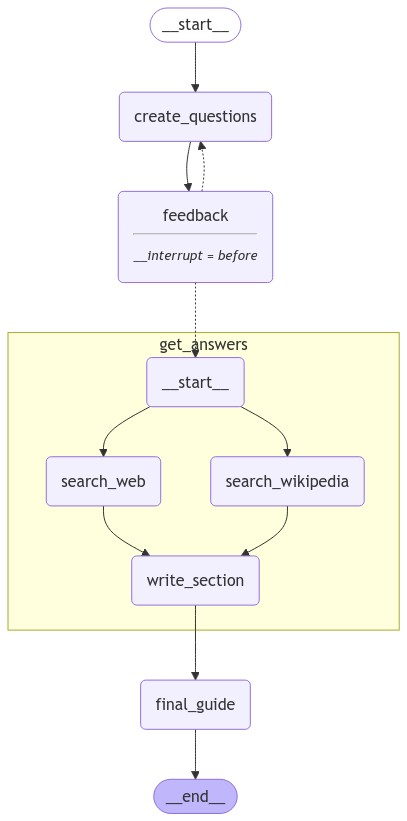

In [31]:
builder = StateGraph(FinalGraphState)
builder.add_node("create_questions", create_questions)
builder.add_node("feedback", feedback)
builder.add_node("get_answers",answer_builder.compile())
builder.add_node("final_guide",final_guide)

builder.add_edge(START, "create_questions")
builder.add_edge("create_questions", "feedback")
builder.add_conditional_edges("feedback", initiate_all_answers, ["create_questions", "get_answers"])
builder.add_edge("get_answers","final_guide")
builder.add_edge("final_guide",END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=['feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [32]:
grade = "9th"
subject = "history"
max_questions = 3
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"grade":grade,"subject":subject,"max_questions":max_questions}, thread, stream_mode="values"):
    # Review
    questions = event.get('questions', '')
    if questions:
        for idx,question in enumerate(questions):
            print(f"Question {idx}: {question.question}")
            print("-" * 50)  

Question 0: What were the primary causes of World War I?
--------------------------------------------------
Question 1: How did the Industrial Revolution impact the social and economic structures of Europe?
--------------------------------------------------
Question 2: What were the key factors that led to the rise of the Roman Empire?
--------------------------------------------------


In [33]:
graph.update_state(thread, {"human_feedback": 
                            "Add one question related to India and rest for world"}, as_node="feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdae25-ea90-6586-8002-ff74c0be18d6'}}

In [34]:
for event in graph.stream({"grade":grade,"subject":subject,"max_questions":max_questions}, thread, stream_mode="values"):
    # Review
    questions = event.get('questions', '')
    if questions:
        for idx,question in enumerate(questions):
            print(f"Question{idx}: {question.question}")
            print("-" * 50)  

Question0: What were the primary causes of World War I?
--------------------------------------------------
Question1: How did the Industrial Revolution impact the social and economic structures of Europe?
--------------------------------------------------
Question2: What were the key factors that led to the rise of the Roman Empire?
--------------------------------------------------


Question0: What were the major factors that led to the Indian independence movement?
--------------------------------------------------
Question1: How did the ancient civilizations of Mesopotamia contribute to the development of modern society?
--------------------------------------------------
Question2: What were the primary causes and consequences of World War II?
--------------------------------------------------


In [35]:
graph.update_state(thread, {"human_feedback": 
                            None}, as_node="feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdae25-f1d4-6ac9-8006-53b3ab66c1ba'}}

In [36]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
get_answers
--Node--
get_answers
--Node--
get_answers
--Node--
final_guide


In [40]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_document')
Markdown(report)

Ans
# Introduction to the Indian Independence Movement
The Indian independence movement was a series of historic events in South Asia with the ultimate aim of ending British colonial rule. It lasted until 1947, when the Indian Independence Act 1947 was passed. The movement was characterized by the emergence of various nationalist and revolutionary groups, who employed different strategies, including non-violent civil disobedience and armed rebellion, to achieve their goal of independence.

## Early British Colonialism in India
The British established their presence in India in the early 17th century, with the first English trading post set up at Surat in 1613. Over the next two centuries, the British defeated the Portuguese and Dutch, and established themselves as a major player in Indian affairs. The decline of the Mughal Empire in the first half of the 18th century allowed the British to gain administrative rights over Bengal, Bihar, and Odisha. The British subsequently seized control of regions ruled by the Maratha Empire and the Sikh Empire, after defeating them in a series of wars.

## Factors Leading to the Indian Independence Movement
Several factors contributed to the emergence of the Indian independence movement. These include:
* The introduction of English education in 1835, which exposed Indians to Western ideas of liberty, equality, and democracy.
* The partition of Bengal in 1905, which led to widespread protests and the emergence of revolutionary groups.
* The Rowlatt Act of 1919, which permitted indefinite detention and sparked protests across India.
* The Jallianwala Bagh massacre of 1919, which further galvanized the movement.
* The influence of nationalist leaders such as Mahatma Gandhi, Jawaharlal Nehru, and Subhas Chandra Bose.

## Key Events and Movements
Some key events and movements that played a significant role in the Indian independence movement include:
* The Swadeshi Movement, which aimed to promote Indian-made goods and boycott British products.
* The formation of the Indian National Congress, which became a major platform for nationalist leaders.
* The Non-Cooperation Movement, led by Mahatma Gandhi, which employed non-violent civil disobedience to challenge British rule.
* The Quit India Movement, which was launched by Gandhi in 1942 and called for immediate independence.
* The Revolutionary Movement, which comprised armed rebellion and terrorist activities against the British.

## Regional Movements
The Indian independence movement was not limited to a single region, but was a pan-Indian phenomenon. Various regional movements and leaders played a significant role in the struggle for independence. These include:
* The Bengal Revolution, which was led by figures such as Aurobindo Ghosh and Subhas Chandra Bose.
* The Andhra Pradesh movement, which was led by leaders such as Alluri Sitarama Raju.
* The Tamil Nadu movement, which was led by figures such as Maveeran Alagumuthu Kone and Puli Thevar.

## Conclusion
The Indian independence movement was a complex and multifaceted phenomenon, which was shaped by a variety of factors and events. The movement ultimately achieved its goal of independence in 1947, but not before undergoing significant transformations and challenges. The legacy of the movement continues to shape Indian politics and society to this day.

Ans
# Introduction to Mesopotamia's Contributions
Mesopotamia, often referred to as the cradle of civilization, was home to numerous civilizations that significantly contributed to the development of modern society. The region, which corresponds to modern-day Iraq, Kuwait, and parts of Syria, Turkey, and Iran, was the birthplace of many innovations that are still integral to our daily lives.

## Early Developments in Mesopotamia
The civilizations of Mesopotamia developed several key aspects of modern life, including:
* Writing: Mesopotamians invented cuneiform, one of the earliest forms of writing, which allowed for the recording of laws, business transactions, and literary works.
* The Wheel: The invention of the wheel revolutionized transportation, trade, and warfare, and is still a fundamental component of modern technology.
* Code of Laws: The Code of Hammurabi, created in Babylon, is one of the earliest surviving codes of law and established the principle of rule of law.
* Irrigation: Mesopotamians developed sophisticated irrigation systems, which enabled the cultivation of crops in the fertile plains between the Tigris and Euphrates rivers.
* Beer-Brewing: The ancient Mesopotamians are credited with the invention of beer, which was an important part of their culture and economy.

## The Rise of Civilization
The rise of civilization in Mesopotamia was a gradual process that began with the development of sedentary agriculture. The Natufian culture, which emerged around 12,000 BC, is considered one of the earliest examples of a sedentary society. The Neolithic Revolution, which occurred around 10,000 BC, marked the beginning of intensive agriculture and the development of complex societies. The first cities, such as Uruk and Ur, emerged in Mesopotamia around 4,000 BC and were characterized by dense populations, specialized labor, and complex systems of governance.

## The Legacy of Mesopotamia
The legacy of Mesopotamia can be seen in the many civilizations that followed, including ancient Egypt, Greece, and Rome. The contributions of Mesopotamia to modern society are numerous and profound, and include:
* The development of writing and literature
* The creation of complex systems of governance and law
* The invention of the wheel and other technologies
* The establishment of trade and commerce networks
* The development of sophisticated irrigation systems and agricultural practices

## Conclusion
In conclusion, the ancient civilizations of Mesopotamia made significant contributions to the development of modern society. Their innovations in writing, technology, governance, and agriculture laid the foundation for the rise of complex societies and the development of modern civilization. The legacy of Mesopotamia can be seen in the many civilizations that followed, and their contributions continue to shape our world today.

Ans
# Introduction to World War II
World War II was a global conflict that lasted from 1939 to 1945, involving most of the world's nations, including all of the great powers. The war was fought between two main alliances: the Allies, which consisted of the United States, the United Kingdom, and the Soviet Union, among others, and the Axis powers, which included Germany, Italy, and Japan.

## Causes of World War II
The causes of World War II are complex and multifaceted. Some of the primary causes include:

1. **The Treaty of Versailles**: The treaty that ended World War I imposed harsh penalties on Germany, including significant territorial losses and heavy reparations. This led to widespread resentment and a desire for revenge among the German people.
2. **The Rise of Fascism and Nazism**: The rise of fascist and nationalist ideologies in Germany, Italy, and Japan created an environment in which aggressive militarism and expansionism could thrive.
3. **The Policy of Appeasement**: The policy of appeasement, pursued by Britain and France, involved giving in to Germany's demands in the hope of avoiding war. However, this only emboldened Hitler and allowed him to pursue further aggression.
4. **The Invasion of Poland**: The invasion of Poland by Germany in 1939 marked the beginning of World War II.
5. **The Failure of the League of Nations**: The League of Nations, established after World War I to promote international cooperation and prevent future wars, failed to prevent the aggression of Japan, Italy, and Germany.

## Course of the War
The war began in September 1939, when Germany invaded Poland. This was followed by the invasion of Denmark, Norway, Belgium, the Netherlands, and France. The war expanded to include the Soviet Union, the United States, and Japan, and eventually involved most of the world's nations.

## Consequences of World War II
The consequences of World War II were far-reaching and profound. Some of the most significant consequences include:

1. **The Loss of Life**: An estimated 50-80 million people lost their lives in the war, making it the deadliest conflict in human history.
2. **The Destruction of Cities and Infrastructure**: Many cities and towns were destroyed, and infrastructure such as roads, bridges, and buildings were severely damaged.
3. **The Establishment of the United Nations**: The war led to the establishment of the United Nations, an international organization dedicated to promoting peace and security.
4. **The Rise of the United States and the Soviet Union**: The war marked the emergence of the United States and the Soviet Union as superpowers, setting the stage for the Cold War.
5. **The Division of Europe**: The war led to the division of Europe into Eastern and Western blocs, with the Soviet Union dominating the Eastern bloc and the United States and its allies dominating the Western bloc.

## The Two Groups: Allies vs Axis Powers
The war was fought between two main alliances: the Allies and the Axis powers. The Allies consisted of the United States, the United Kingdom, the Soviet Union, and other nations, while the Axis powers included Germany, Italy, and Japan.

## Ultimate Causes of World War II
The ultimate causes of World War II are complex and multifaceted. Some of the most significant ultimate causes include:

1. **The Legacy of World War I**: The Treaty of Versailles and the aftermath of World War I created an environment in which another war could occur.
2. **The Rise of Nationalism and Fascism**: The rise of nationalist and fascist ideologies in Germany, Italy, and Japan created an environment in which aggressive militarism and expansionism could thrive.
3. **The Failure of the International System**: The failure of the League of Nations and the international system to prevent aggression and promote cooperation created an environment in which war could occur.

In conclusion, World War II was a complex and multifaceted conflict that was caused by a variety of factors, including the legacy of World War I, the rise of nationalism and fascism, and the failure of the international system. The war had far-reaching and profound consequences, including the loss of life, the destruction of cities and infrastructure, and the establishment of the United Nations.